In [1]:
!pip install pandas
!pip install nltk
!pip install hdbscan

!pip install --upgrade umap-learn


In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF, PCA

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, Birch
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import (
    homogeneity_score, 
    normalized_mutual_info_score,
    completeness_score, 
    v_measure_score,
    silhouette_score,
    adjusted_rand_score, 
    adjusted_mutual_info_score, 
    confusion_matrix
)

import umap.umap_ as umap
import hdbscan
from sklearn.manifold import TSNE
from nltk.stem import SnowballStemmer
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import linear_sum_assignment
from time import time
import warnings

warnings.filterwarnings('ignore')

/Users/rickyang/.pyenv/versions/3.10.12/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## QUESTION 1: 
Report the dimensions of the TF-IDF matrix you obtain.

In [3]:
# Define two categories
categories = [
    'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
    'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey'
]

# Load the dataset
#print("Loading the dataset...")
newsgroups = fetch_20newsgroups(subset='all', categories=categories, remove=('headers', 'footers', 'quotes'))
print("Dataset loaded!")
print("Number of samples:", len(newsgroups.data))
print("Number of categories:", len(newsgroups.target_names))
print("First 5 sample categories:", newsgroups.target[:5])

# Index categories from 0 to 7
for i, target_name in enumerate(newsgroups.target_names):
    print(f"{target_name}: target index = {i}")

# Convert the original categories to two categories
# Category 1: comp.* (0, 1, 2, 3)
# Category 2: rec.* (4, 5, 6, 7)
print("\nConverting original categories to two categories...")
binary_labels = [0 if label < 4 else 1 for label in newsgroups.target]
print("Category conversion completed!")
print("First 5 converted categories:", binary_labels[:5])

# Generate TF-IDF representation
print("\nGenerating TF-IDF representation...")
vectorizer = TfidfVectorizer(min_df=3, stop_words='english')
tfidf = vectorizer.fit_transform(newsgroups.data)
print("TF-IDF representation generated!")
print("Dimensions of the TF-IDF matrix:", tfidf.shape)
print("Vocabulary size:", len(vectorizer.get_feature_names_out()))


Dataset loaded!
Number of samples: 7882
Number of categories: 8
First 5 sample categories: [2 1 2 3 6]
comp.graphics: target index = 0
comp.os.ms-windows.misc: target index = 1
comp.sys.ibm.pc.hardware: target index = 2
comp.sys.mac.hardware: target index = 3
rec.autos: target index = 4
rec.motorcycles: target index = 5
rec.sport.baseball: target index = 6
rec.sport.hockey: target index = 7

Converting original categories to two categories...
Category conversion completed!
First 5 converted categories: [0, 0, 0, 0, 1]

Generating TF-IDF representation...
TF-IDF representation generated!
Dimensions of the TF-IDF matrix: (7882, 18469)
Vocabulary size: 18469


## QUESTION 2:


Clustering using K-means...
K-means clustering completed!
Clustering labels: [1 0 0 1 1 1 0 1 0 1]
True labels: [0, 0, 0, 0, 1, 1, 0, 1, 0, 1]

Generating contingency table...
Contingency table generated!
Contingency table:
[[2563 1340]
 [  36 3943]]
Contingency table shape: (2, 2)


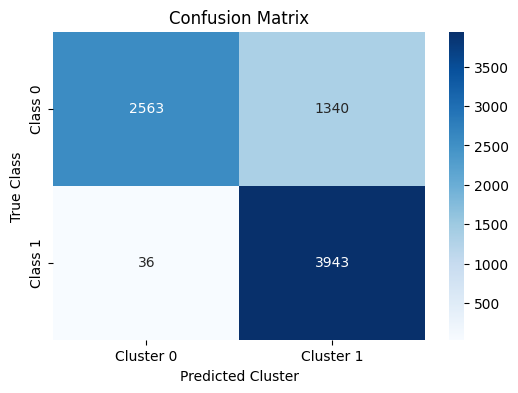

In [4]:
print("\nClustering using K-means...")
kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30)
kmeans.fit(tfidf)
print("K-means clustering completed!")

# Get the clustering labels
cluster_labels = kmeans.labels_
print("Clustering labels:", cluster_labels[:10])  # Print the clustering labels of the first 10 samples
print("True labels:", binary_labels[:10])  # Print the true labels of the first 10 samples

# Generate the contingency table
print("\nGenerating contingency table...")
contingency_table = confusion_matrix(binary_labels, cluster_labels)
print("Contingency table generated!")
print("Contingency table:")
print(contingency_table)

# The contingency table is not necessarily square; its shape is (true categories × clusters)
print("Contingency table shape:", contingency_table.shape)

# Generate confusion matrix
conf_matrix = confusion_matrix(binary_labels, cluster_labels)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Cluster 0', 'Cluster 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Cluster')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()


## QUESTION 3: 
Report the 5 clustering measures explained in the introduction for K-means clustering

In [5]:
# Calculate clustering metrics
print("\nCalculating clustering metrics...")

# Calculate five metrics
ari = adjusted_rand_score(binary_labels, cluster_labels)
nmi = normalized_mutual_info_score(binary_labels, cluster_labels)
homogeneity = homogeneity_score(binary_labels, cluster_labels)
completeness = completeness_score(binary_labels, cluster_labels)
v_measure = v_measure_score(binary_labels, cluster_labels)

print("Clustering metrics calculation completed!")

# Report clustering metrics
print("\nClustering metrics results:")
print("Adjusted Rand Index (ARI):", ari)
print("Normalized Mutual Information (NMI):", nmi)
print("Homogeneity:", homogeneity)
print("Completeness:", completeness)
print("V-Measure:", v_measure)



Calculating clustering metrics...
Clustering metrics calculation completed!

Clustering metrics results:
Adjusted Rand Index (ARI): 0.4235348988973707
Normalized Mutual Information (NMI): 0.4362142897362819
Homogeneity: 0.41761421534460047
Completeness: 0.45654845188009097
V-Measure: 0.43621428973628196


# Question 4: 
Plot the cumulative explained variance ratio for the first 1000 components

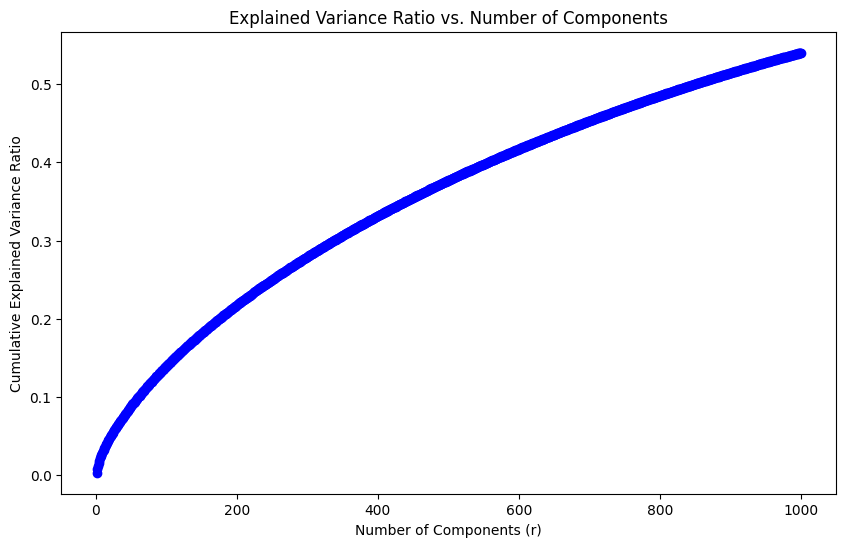

In [6]:
# Use TruncatedSVD to calculate the explained variance ratio for the first 1000 components
svd = TruncatedSVD(n_components=1000, random_state=0)
svd.fit(tfidf)

# Calculate the cumulative explained variance ratio
explained_variance_ratio = svd.explained_variance_ratio_.cumsum()

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, 1001), explained_variance_ratio, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Components (r)')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
# plt.grid(True)
plt.show()


# Question 5-7: Comparing clustering metrics for SVD and NMF with different dimensions (r)

In [7]:


# R Values (using log-spaced values for better visualization)
r_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 300]

# Initialize lists to store all metrics for both methods
metrics = {
    'svd': {
        'homogeneity': [],
        'completeness': [],
        'v_measure': [],
        'ari': [],
        'nmi': []
    },
    'nmf': {
        'homogeneity': [],
        'completeness': [],
        'v_measure': [],
        'ari': [],
        'nmi': []
    }
}

# Convert binary labels (assuming you have newsgroups.target)
binary_labels = [0 if label < 4 else 1 for label in newsgroups.target]

# Process each r value
for r in r_values:
    print(f'Processing r = {r}')
    
    # SVD reduction
    svd = TruncatedSVD(n_components=r, random_state=42)
    svd_data = svd.fit_transform(tfidf)
    
    # K-means Clustering with SVD
    kmeans_svd = KMeans(n_clusters=2, random_state=42, max_iter=1000, n_init=30)
    kmeans_svd.fit(svd_data)
    
    # Calculate SVD metrics
    metrics['svd']['homogeneity'].append(homogeneity_score(binary_labels, kmeans_svd.labels_))
    metrics['svd']['completeness'].append(completeness_score(binary_labels, kmeans_svd.labels_))
    metrics['svd']['v_measure'].append(v_measure_score(binary_labels, kmeans_svd.labels_))
    metrics['svd']['ari'].append(adjusted_rand_score(binary_labels, kmeans_svd.labels_))
    metrics['svd']['nmi'].append(adjusted_mutual_info_score(binary_labels, kmeans_svd.labels_))
    
    try:
        # NMF reduction
        nmf = NMF(
            n_components=r,
            init='nndsvda',
            max_iter=1000,
            random_state=42
        )
        nmf_data = nmf.fit_transform(tfidf)
        
        # K-means Clustering with NMF
        kmeans_nmf = KMeans(n_clusters=2, random_state=42, max_iter=1000, n_init=30)
        kmeans_nmf.fit(nmf_data)
        
        # Calculate NMF metrics
        metrics['nmf']['homogeneity'].append(homogeneity_score(binary_labels, kmeans_nmf.labels_))
        metrics['nmf']['completeness'].append(completeness_score(binary_labels, kmeans_nmf.labels_))
        metrics['nmf']['v_measure'].append(v_measure_score(binary_labels, kmeans_nmf.labels_))
        metrics['nmf']['ari'].append(adjusted_rand_score(binary_labels, kmeans_nmf.labels_))
        metrics['nmf']['nmi'].append(adjusted_mutual_info_score(binary_labels, kmeans_nmf.labels_))
        
    except Exception as e:
        print(f'NMF failed for r={r}: {str(e)}')
        # Append zeros if NMF fails
        for metric in metrics['nmf']:
            metrics['nmf'][metric].append(0.0)



Processing r = 1
Processing r = 2
Processing r = 3
Processing r = 4
Processing r = 5
Processing r = 6
Processing r = 7
Processing r = 8
Processing r = 9
Processing r = 10
Processing r = 20
Processing r = 50
Processing r = 100
Processing r = 300


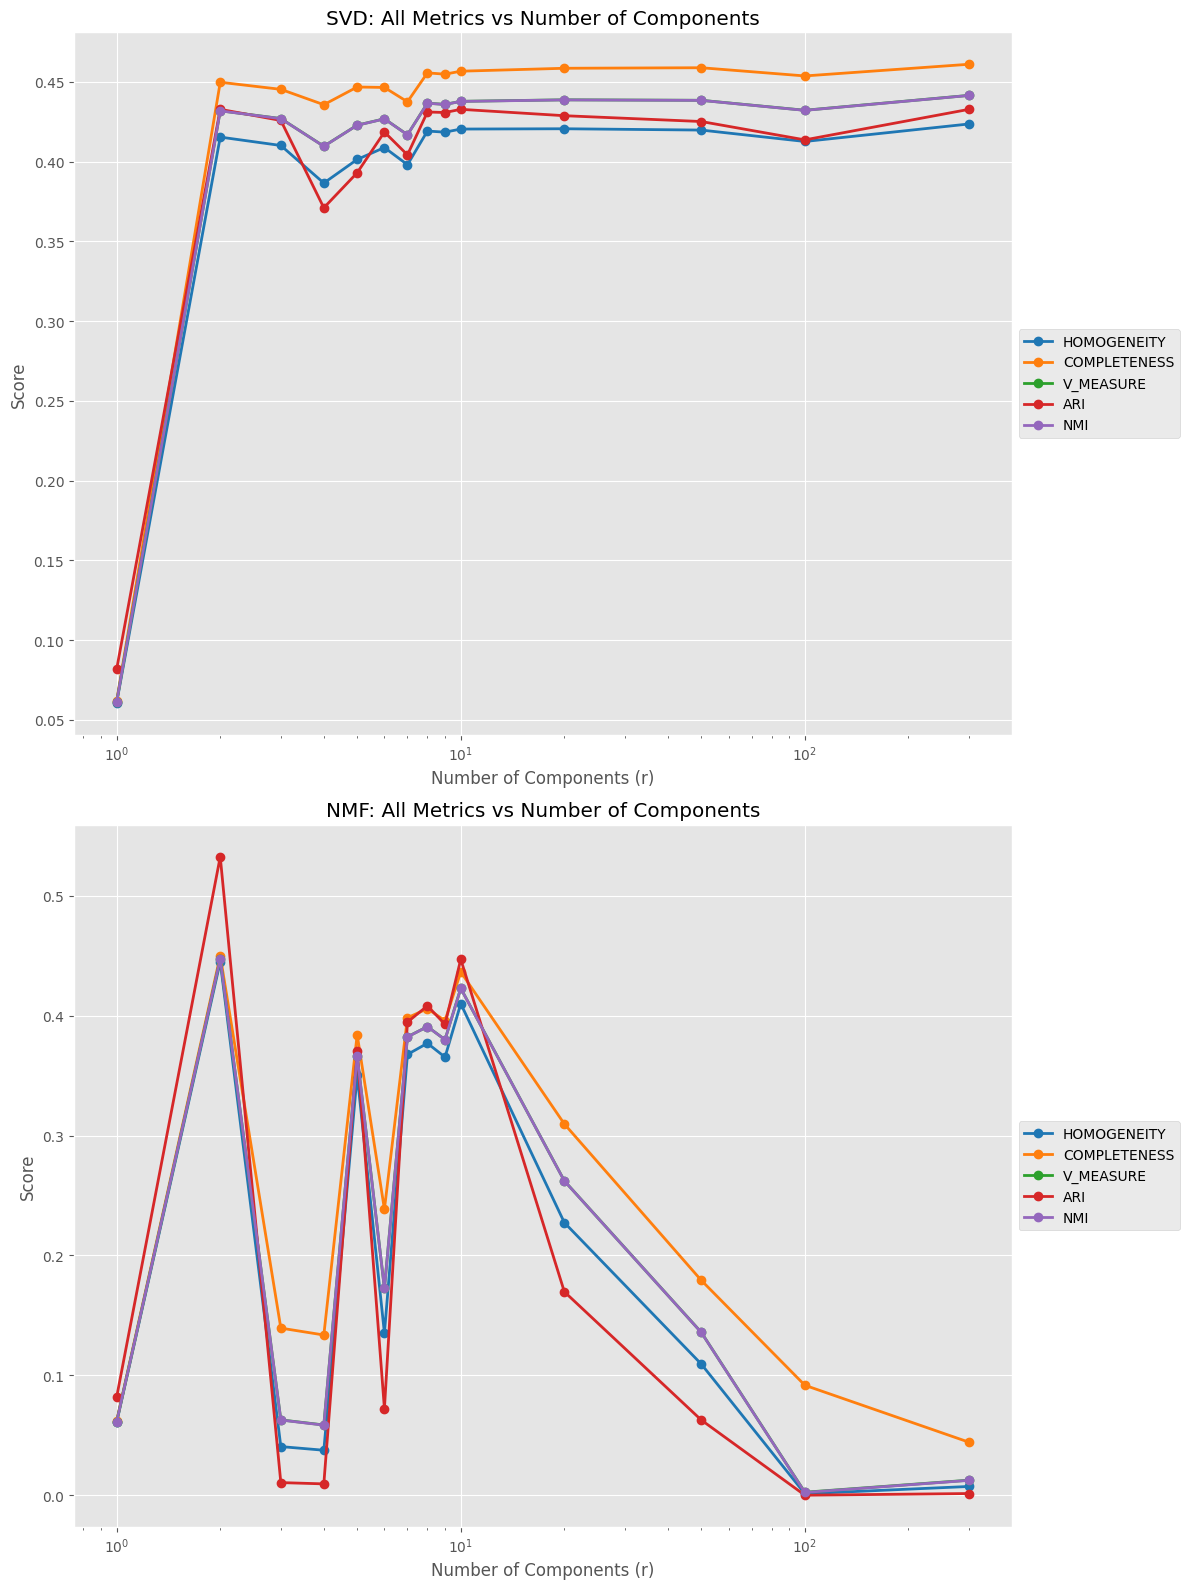


Optimal results:

SVD Results:
HOMOGENEITY  - Best r: 300, Score: 0.4237
COMPLETENESS - Best r: 300, Score: 0.4611
V_MEASURE    - Best r: 300, Score: 0.4416
ARI          - Best r: 300, Score: 0.4328
NMI          - Best r: 300, Score: 0.4415

NMF Results:
HOMOGENEITY  - Best r:   2, Score: 0.4451
COMPLETENESS - Best r:   2, Score: 0.4500
V_MEASURE    - Best r:   2, Score: 0.4475
ARI          - Best r:   2, Score: 0.5325
NMI          - Best r:   2, Score: 0.4475


In [8]:
# Plotting
plt.style.use('ggplot')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

# Colors for different metrics
colors = {
    'homogeneity': '#1f77b4',
    'completeness': '#ff7f0e',
    'v_measure': '#2ca02c',
    'ari': '#d62728',
    'nmi': '#9467bd'
}

# Plot SVD metrics
for metric, values in metrics['svd'].items():
    ax1.plot(r_values, values, marker='o', label=metric.upper(), color=colors[metric], linewidth=2)

ax1.set_xscale('log')
ax1.set_xlabel('Number of Components (r)')
ax1.set_ylabel('Score')
ax1.set_title('SVD: All Metrics vs Number of Components')
ax1.grid(True)
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Plot NMF metrics
for metric, values in metrics['nmf'].items():
    ax2.plot(r_values, values, marker='o', label=metric.upper(), color=colors[metric], linewidth=2)

ax2.set_xscale('log')
ax2.set_xlabel('Number of Components (r)')
ax2.set_ylabel('Score')
ax2.set_title('NMF: All Metrics vs Number of Components')
ax2.grid(True)
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

# Print optimal results for each metric and method
print("\nOptimal results:")
for method in ['svd', 'nmf']:
    print(f"\n{method.upper()} Results:")
    for metric in metrics[method]:
        max_score = max(metrics[method][metric])
        optimal_r = r_values[metrics[method][metric].index(max_score)]
        print(f"{metric.upper():12} - Best r: {optimal_r:3d}, Score: {max_score:.4f}")

# Question 8 & 9

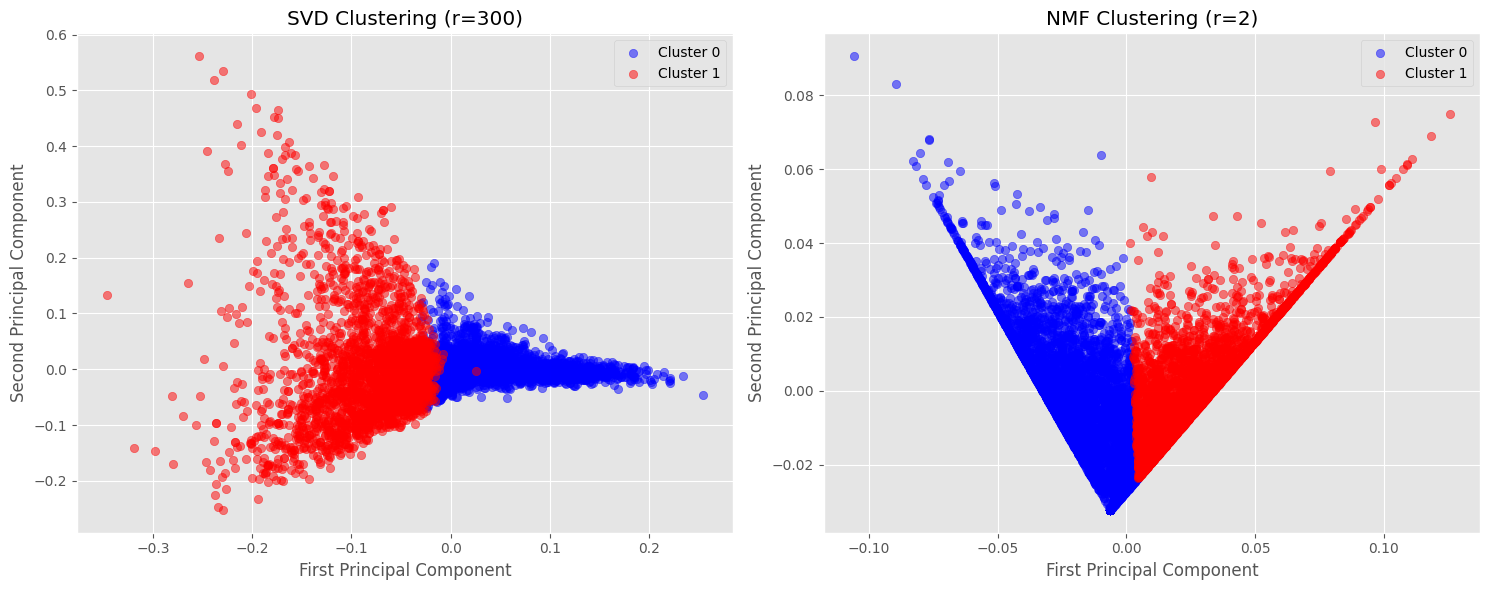

In [9]:


# Function to create 2D projection of data
def project_to_2d(data):
    pca = PCA(n_components=2)
    return pca.fit_transform(data)

# Create SVD representation with optimal r=300
svd_optimal = TruncatedSVD(n_components=300, random_state=42)
svd_data = svd_optimal.fit_transform(tfidf)
kmeans_svd = KMeans(n_clusters=2, random_state=42, max_iter=1000, n_init=30)
svd_labels = kmeans_svd.fit_predict(svd_data)

# Create NMF representation with optimal r=2
nmf_optimal = NMF(n_components=2, init='nndsvda', max_iter=1000, random_state=42)
nmf_data = nmf_optimal.fit_transform(tfidf)
kmeans_nmf = KMeans(n_clusters=2, random_state=42, max_iter=1000, n_init=30)
nmf_labels = kmeans_nmf.fit_predict(nmf_data)

# Project the data to 2D for visualization
svd_2d = project_to_2d(svd_data)
nmf_2d = project_to_2d(nmf_data)

# Create scatter plots
plt.figure(figsize=(15, 6))

# SVD plot
plt.subplot(121)
plt.scatter(svd_2d[svd_labels == 0, 0], svd_2d[svd_labels == 0, 1], 
           c='blue', label='Cluster 0', alpha=0.5)
plt.scatter(svd_2d[svd_labels == 1, 0], svd_2d[svd_labels == 1, 1], 
           c='red', label='Cluster 1', alpha=0.5)
plt.title('SVD Clustering (r=300)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()

# NMF plot
plt.subplot(122)
plt.scatter(nmf_2d[nmf_labels == 0, 0], nmf_2d[nmf_labels == 0, 1], 
           c='blue', label='Cluster 0', alpha=0.5)
plt.scatter(nmf_2d[nmf_labels == 1, 0], nmf_2d[nmf_labels == 1, 1], 
           c='red', label='Cluster 1', alpha=0.5)
plt.title('NMF Clustering (r=2)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()

plt.tight_layout()
plt.show()

# Q10

Clustering Metrics for SVD:
Homogeneity Score: 0.25762380069949004
Completeness Score: 0.2930943066505179
V-measure Score: 0.2742167662001323
Adjusted Rand Index: 0.08220070867454365
Adjusted Mutual Info Score: 0.271706616464799

Clustering Metrics for NMF:
Homogeneity Score: 0.2562941261665178
Completeness Score: 0.297306107908675
V-measure Score: 0.2752809859544703
Adjusted Rand Index: 0.07803155758473546
Adjusted Mutual Info Score: 0.2727491111160069


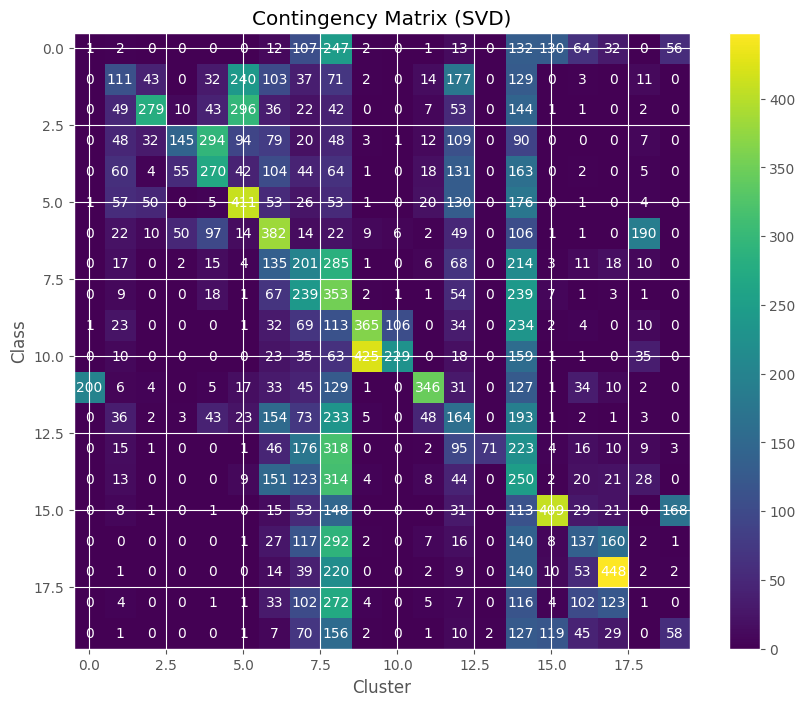

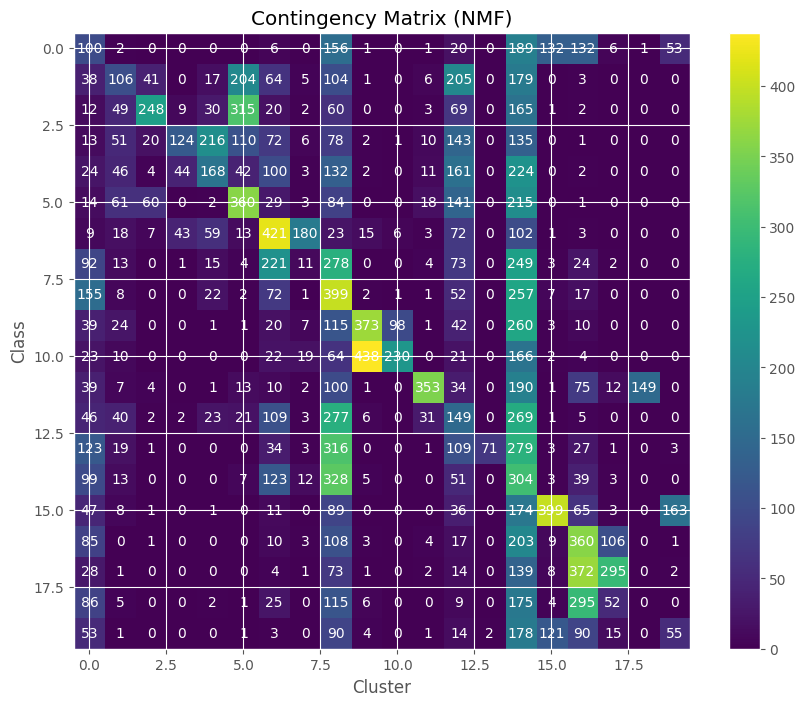

In [10]:

# Load documents for all 20 categories
newsgroups_data = fetch_20newsgroups(subset='all', random_state = 0, 
                                     remove = ('headers', 'footers', 'quotes'))

# Convert documents to TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', min_df = 3)
tfidf_vectors = tfidf_vectorizer.fit_transform(newsgroups_data.data)

# Define the number of clusters
n_clusters = 20

# Define the best r values
best_r_svd = 9
best_r_nmf = 10

# Reduce dimensionality using Truncated SVD (PCA) with the best r value
svd = TruncatedSVD(n_components = best_r_svd, random_state = 0)
svd_data = svd.fit_transform(tfidf_vectors)

# Reduce dimensionality using NMF with the best r value
nmf = NMF(n_components = best_r_nmf, random_state = 0)
nmf_data = nmf.fit_transform(tfidf_vectors)

# Perform K-Means clustering with k=20 for both SVD and NMF
kmeans_svd = KMeans(n_clusters = n_clusters, random_state = 0, max_iter = 1000, n_init = 30)
kmeans_nmf = KMeans(n_clusters = n_clusters, random_state = 0, max_iter = 1000, n_init = 30)

# Fit K-Means to the dimension-reduced data
kmeans_svd.fit(svd_data)
kmeans_nmf.fit(nmf_data)

# Calculate clustering metrics for SVD
svd_homogeneity = homogeneity_score(newsgroups_data.target, kmeans_svd.labels_)
svd_completeness = completeness_score(newsgroups_data.target, kmeans_svd.labels_)
svd_v_measure = v_measure_score(newsgroups_data.target, kmeans_svd.labels_)
svd_ari = adjusted_rand_score(newsgroups_data.target, kmeans_svd.labels_)
svd_ami = adjusted_mutual_info_score(newsgroups_data.target, kmeans_svd.labels_)

# Calculate clustering metrics for NMF
nmf_homogeneity = homogeneity_score(newsgroups_data.target, kmeans_nmf.labels_)
nmf_completeness = completeness_score(newsgroups_data.target, kmeans_nmf.labels_)
nmf_v_measure = v_measure_score(newsgroups_data.target, kmeans_nmf.labels_)
nmf_ari = adjusted_rand_score(newsgroups_data.target, kmeans_nmf.labels_)
nmf_ami = adjusted_mutual_info_score(newsgroups_data.target, kmeans_nmf.labels_)

# Print clustering metrics for SVD
print("Clustering Metrics for SVD:")
print("Homogeneity Score:", svd_homogeneity)
print("Completeness Score:", svd_completeness)
print("V-measure Score:", svd_v_measure)
print("Adjusted Rand Index:", svd_ari)
print("Adjusted Mutual Info Score:", svd_ami)

# Print clustering metrics for NMF
print("\nClustering Metrics for NMF:")
print("Homogeneity Score:", nmf_homogeneity)
print("Completeness Score:", nmf_completeness)
print("V-measure Score:", nmf_v_measure)
print("Adjusted Rand Index:", nmf_ari)
print("Adjusted Mutual Info Score:", nmf_ami)

# Calculate contingency matrix for SVD
cm_svd = confusion_matrix(newsgroups_data.target, kmeans_svd.labels_)

# Calculate contingency matrix for NMF
cm_nmf = confusion_matrix(newsgroups_data.target, kmeans_nmf.labels_)

# Reorder the contingency matrix for SVD
rows_svd, cols_svd = linear_sum_assignment(cm_svd, maximize = True)
cm_svd_reordered = cm_svd[rows_svd[:, np.newaxis], cols_svd]

# Reorder the contingency matrix for NMF
rows_nmf, cols_nmf = linear_sum_assignment(cm_nmf, maximize = True)
cm_nmf_reordered = cm_nmf[rows_nmf[:, np.newaxis], cols_nmf]


# Plot contingency matrix for SVD
plt.figure(figsize=(10, 8))
plt.imshow(cm_svd_reordered, interpolation = 'nearest', cmap = 'viridis')
plt.title('Contingency Matrix (SVD)')
plt.colorbar()
plt.xlabel('Cluster')
plt.ylabel('Class')

# Display numbers within the matrix
for i in range(cm_svd_reordered.shape[0]):
    for j in range(cm_svd_reordered.shape[1]):
        plt.text(j, i, cm_svd_reordered[i, j], ha = 'center', va = 'center', color = 'white')

plt.show()

# Plot contingency matrix for NMF
plt.figure(figsize=(10, 8))
plt.imshow(cm_nmf_reordered, interpolation = 'nearest', cmap = 'viridis')
plt.title('Contingency Matrix (NMF)')
plt.colorbar()
plt.xlabel('Cluster')
plt.ylabel('Class')

# Display numbers within the matrix
for i in range(cm_nmf_reordered.shape[0]):
    for j in range(cm_nmf_reordered.shape[1]):
        plt.text(j, i, cm_nmf_reordered[i, j], ha = 'center', va = 'center', color = 'white')

plt.show()

# Q11-13


Processing UMAP(n=5, metric=cosine)


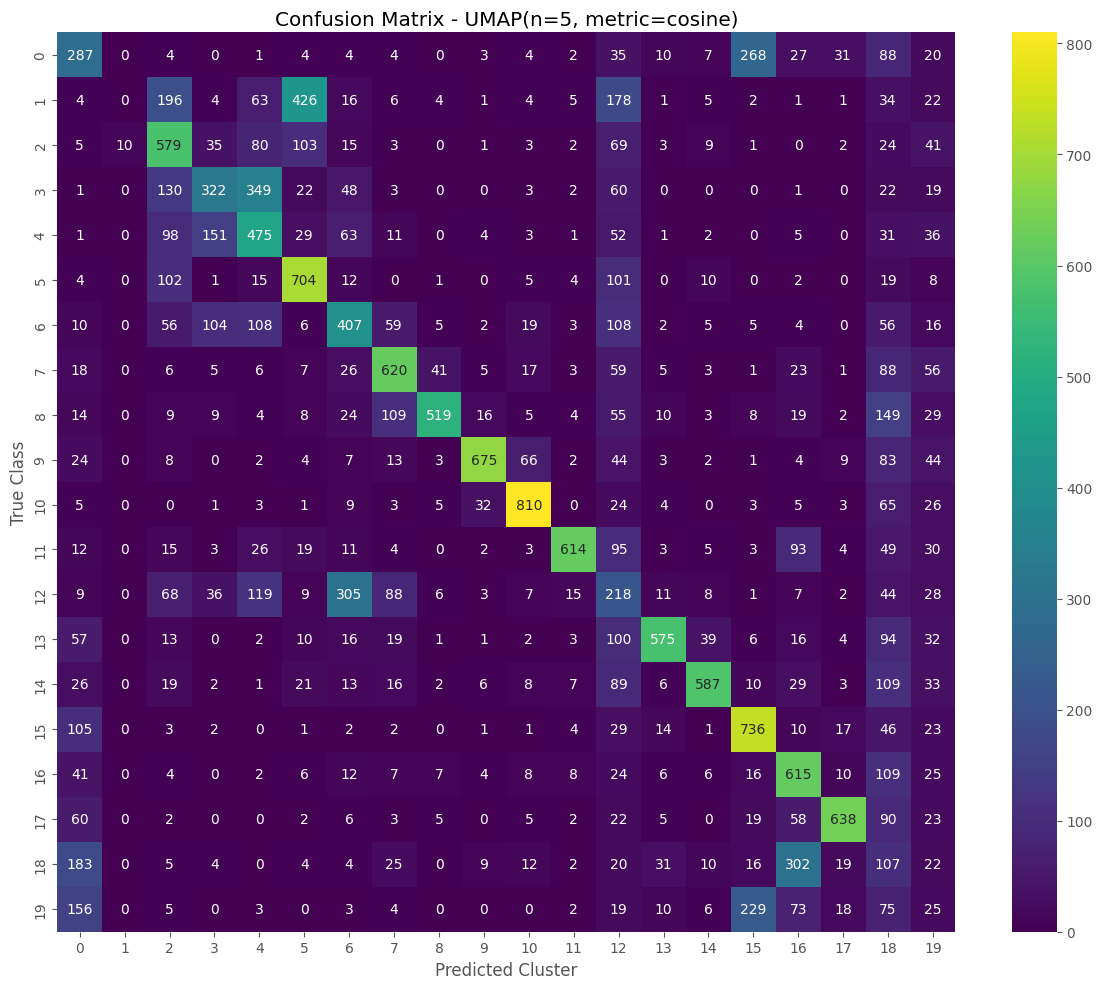


Metrics for UMAP(n=5, metric=cosine):
Homogeneity: 0.4575
Completeness: 0.4713
V-measure: 0.4643
ARI: 0.3168
AMI: 0.4625

Processing UMAP(n=5, metric=euclidean)


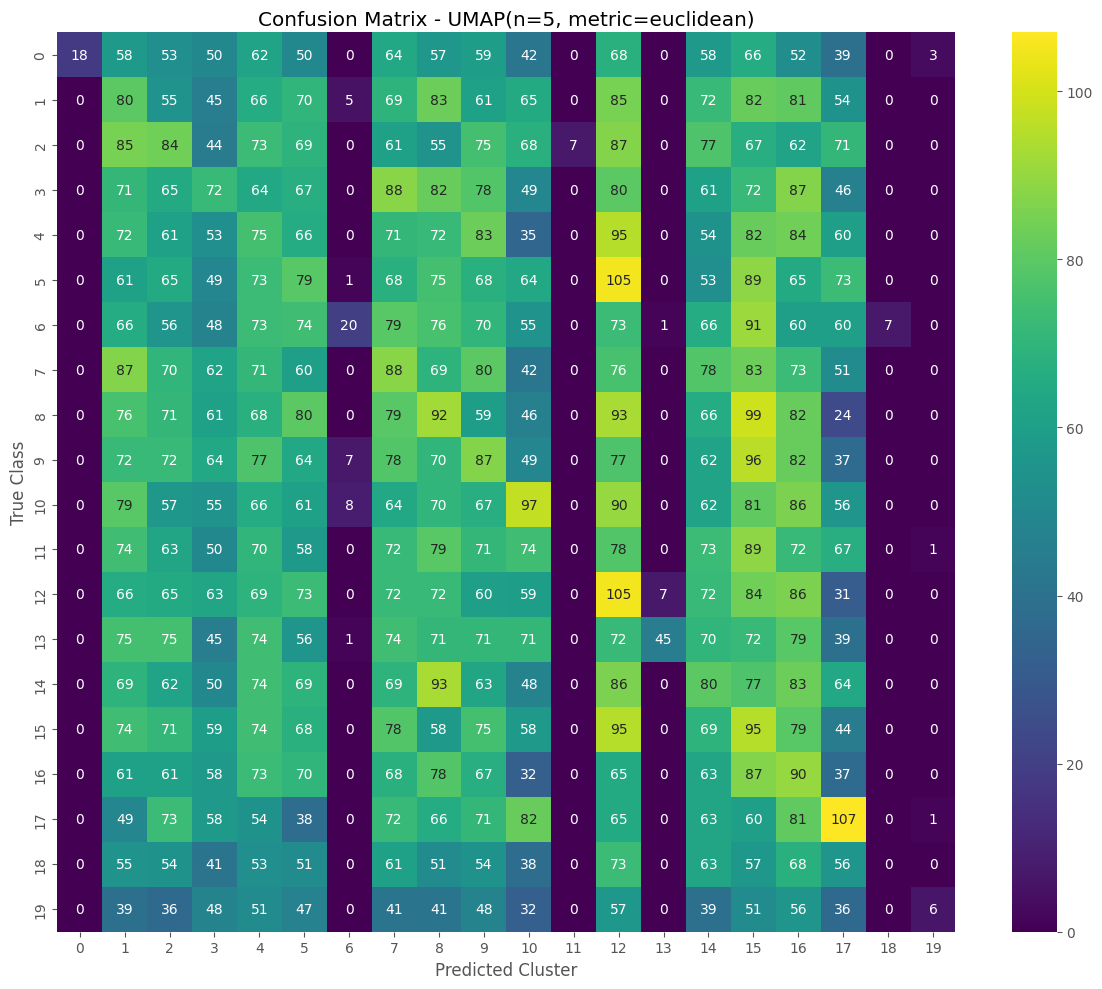


Metrics for UMAP(n=5, metric=euclidean):
Homogeneity: 0.0094
Completeness: 0.0105
V-measure: 0.0099
ARI: 0.0007
AMI: 0.0065

Processing UMAP(n=20, metric=cosine)


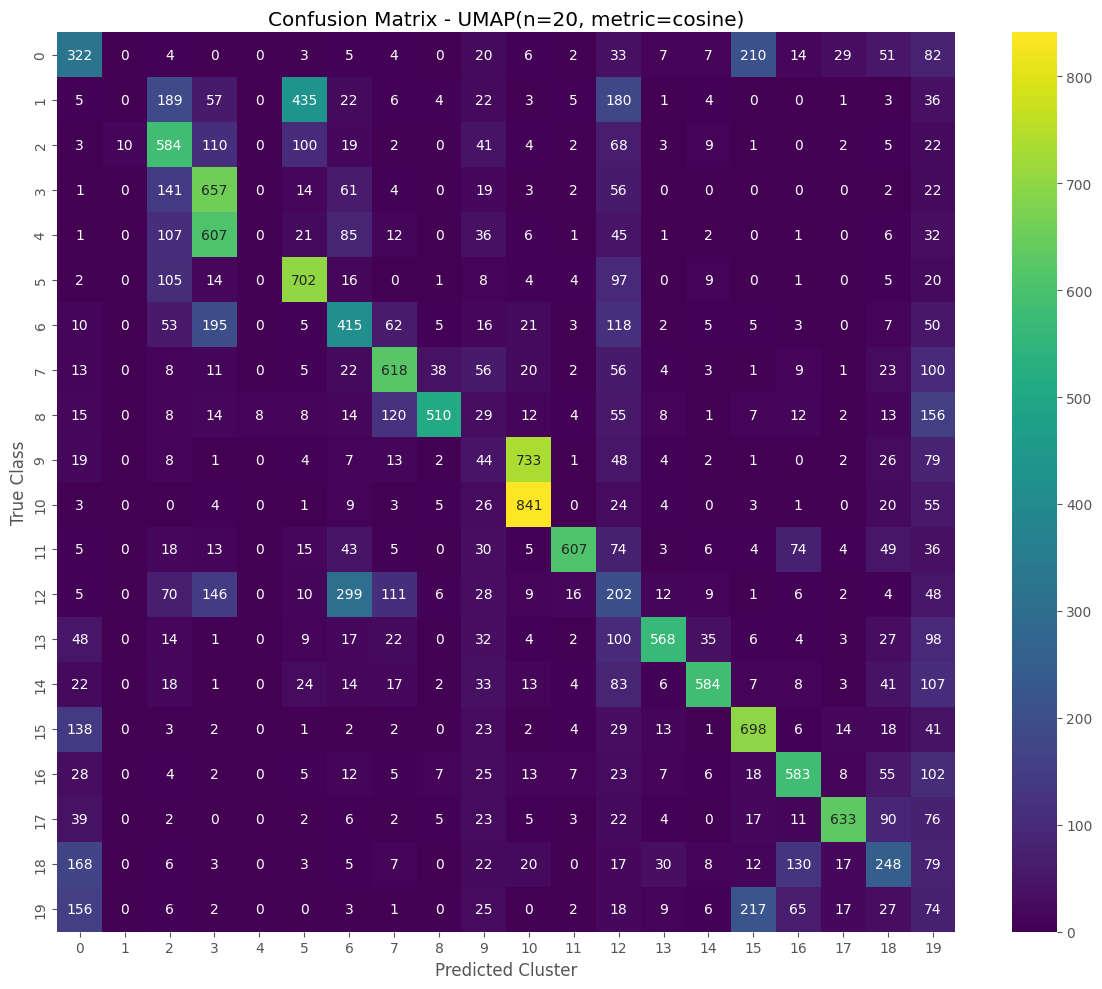


Metrics for UMAP(n=20, metric=cosine):
Homogeneity: 0.4494
Completeness: 0.4743
V-measure: 0.4615
ARI: 0.3155
AMI: 0.4597

Processing UMAP(n=20, metric=euclidean)


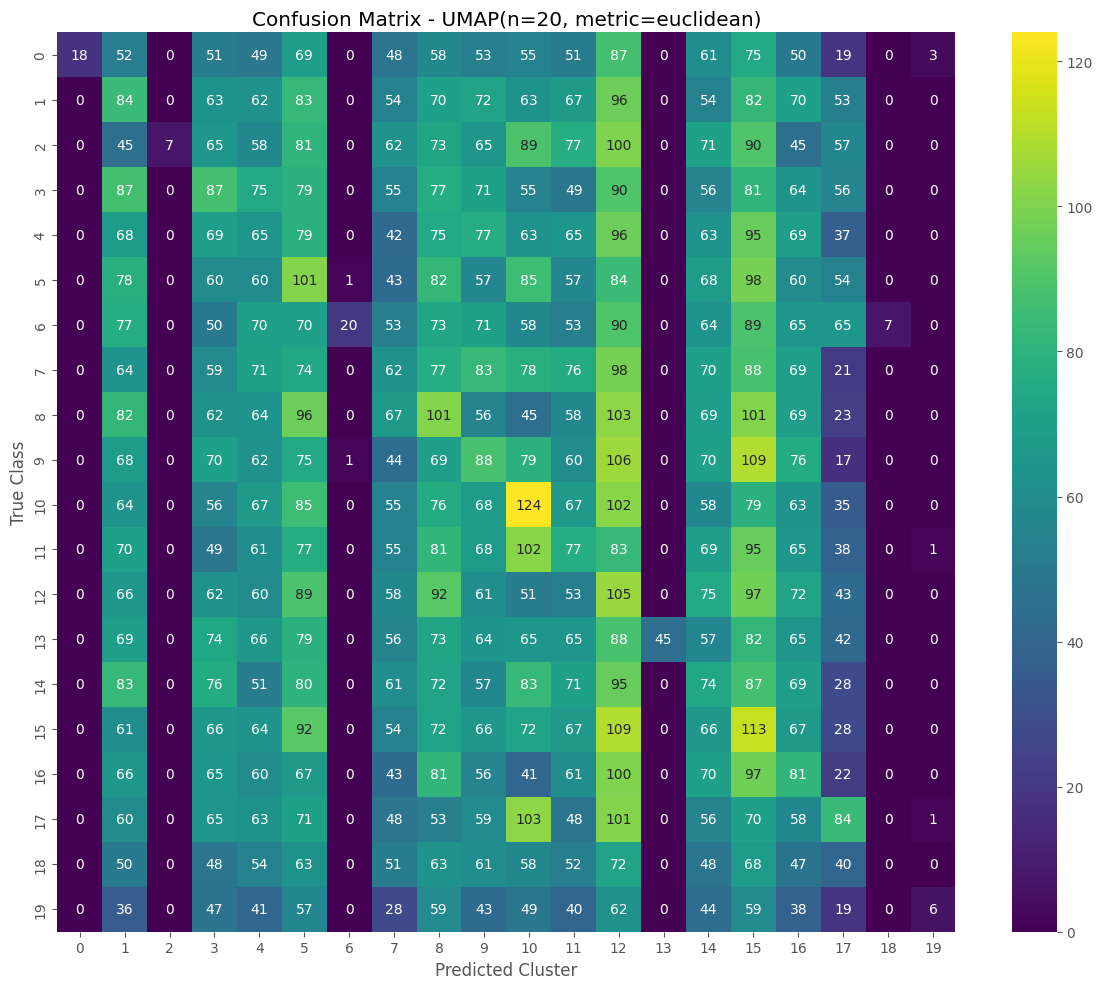


Metrics for UMAP(n=20, metric=euclidean):
Homogeneity: 0.0096
Completeness: 0.0109
V-measure: 0.0102
ARI: 0.0007
AMI: 0.0068

Processing UMAP(n=200, metric=cosine)


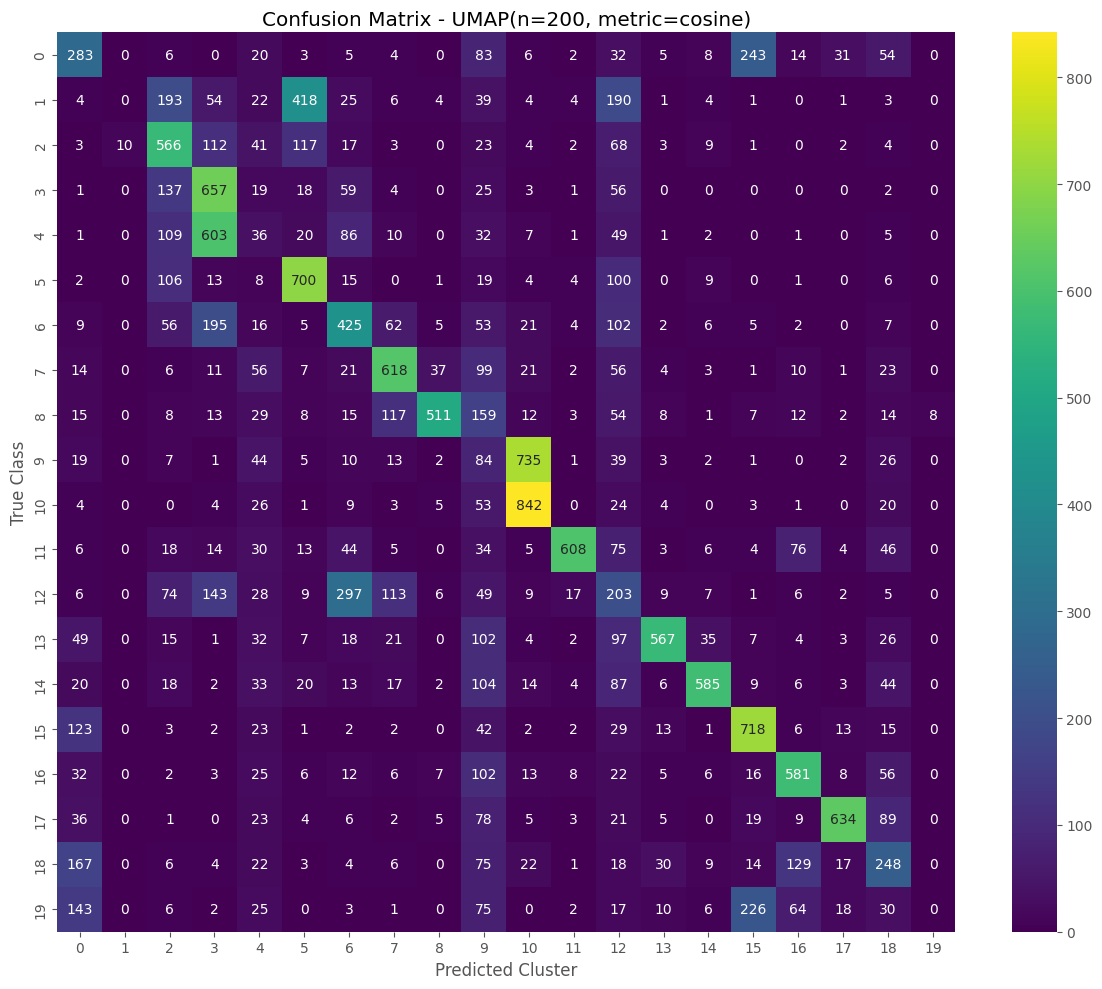


Metrics for UMAP(n=200, metric=cosine):
Homogeneity: 0.4484
Completeness: 0.4735
V-measure: 0.4606
ARI: 0.3148
AMI: 0.4588

Processing UMAP(n=200, metric=euclidean)


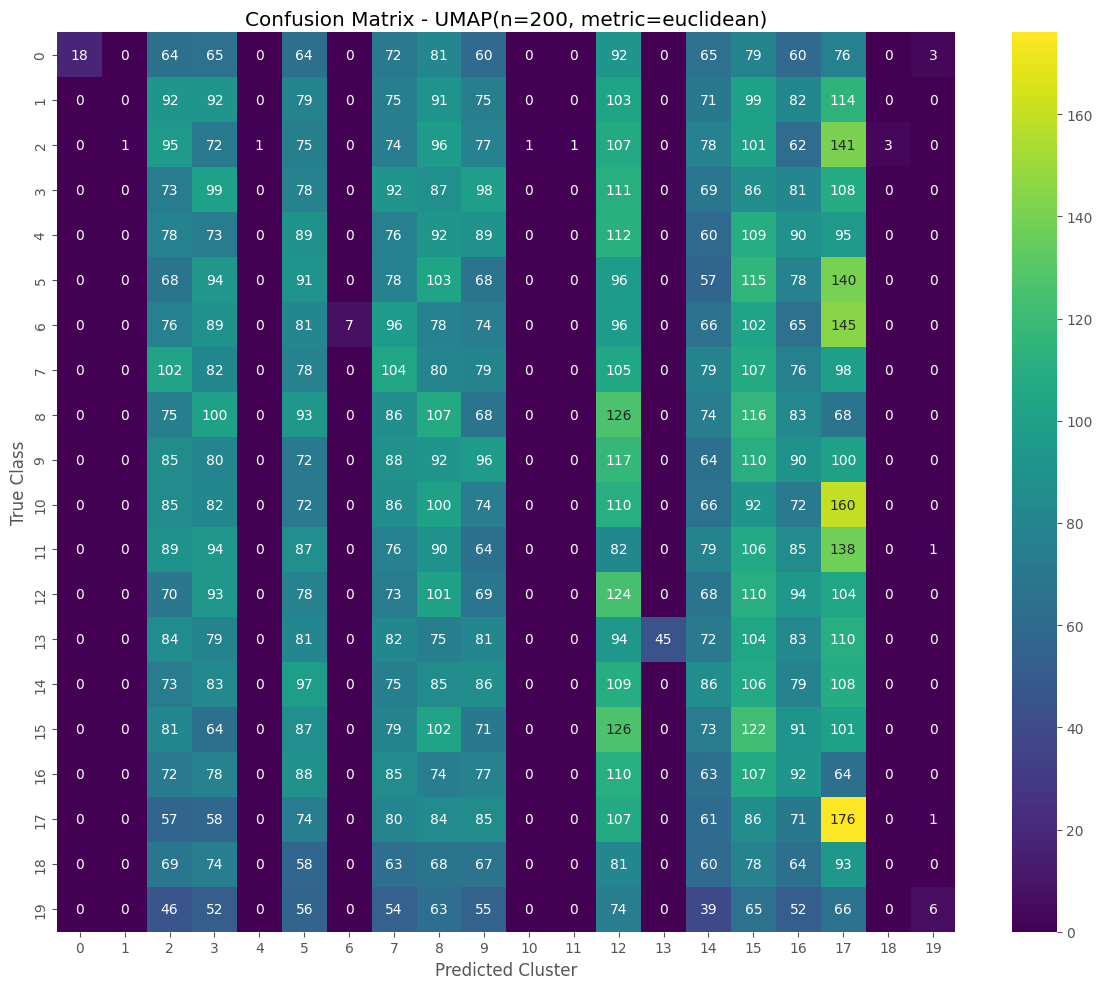


Metrics for UMAP(n=200, metric=euclidean):
Homogeneity: 0.0073
Completeness: 0.0091
V-measure: 0.0081
ARI: 0.0007
AMI: 0.0051

Processing Raw TF-IDF

Processing PCA

Processing NMF


In [11]:

# Load and preprocess data
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
vectorizer = TfidfVectorizer(stop_words='english', min_df=3)
tfidf_matrix = vectorizer.fit_transform(newsgroups.data)

def perform_clustering_analysis(data, true_labels, method_name):
    """Perform K-means clustering and calculate metrics"""
    kmeans = KMeans(n_clusters=20, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(data)
    
    # Calculate metrics
    metrics = {
        'Homogeneity': homogeneity_score(true_labels, cluster_labels),
        'Completeness': completeness_score(true_labels, cluster_labels),
        'V-measure': v_measure_score(true_labels, cluster_labels),
        'ARI': adjusted_rand_score(true_labels, cluster_labels),
        'AMI': adjusted_mutual_info_score(true_labels, cluster_labels)
    }
    
    # Calculate and optimize confusion matrix
    cm = confusion_matrix(true_labels, cluster_labels)
    row_ind, col_ind = linear_sum_assignment(cm, maximize=True)
    cm_optimized = cm[row_ind[:, np.newaxis], col_ind]
    
    return metrics, cm_optimized

def plot_confusion_matrix(cm, title):
    """Plot confusion matrix with improved visibility"""
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, cmap='viridis', annot=True, fmt='d', cbar=True)
    plt.title(title)
    plt.xlabel('Predicted Cluster')
    plt.ylabel('True Class')
    plt.tight_layout()
    plt.show()

# UMAP Analysis (Question 11)
n_components_list = [5, 20, 200]
metrics_list = ['cosine', 'euclidean']
results = {}

for n_comp in n_components_list:
    for metric in metrics_list:
        method_name = f'UMAP(n={n_comp}, metric={metric})'
        print(f"\nProcessing {method_name}")
        
        # UMAP reduction
        reducer = umap.UMAP(n_components=n_comp, metric=metric, random_state=42)
        umap_embedding = reducer.fit_transform(tfidf_matrix)
        
        # Perform clustering and get results
        metrics, cm = perform_clustering_analysis(umap_embedding, newsgroups.target, method_name)
        results[method_name] = {'metrics': metrics, 'cm': cm}
        
        # Plot confusion matrix
        plot_confusion_matrix(cm, f'Confusion Matrix - {method_name}')
        
        # Print metrics
        print(f"\nMetrics for {method_name}:")
        for metric_name, value in metrics.items():
            print(f"{metric_name}: {value:.4f}")

# Baseline methods for comparison (Question 13)
# Raw TF-IDF
print("\nProcessing Raw TF-IDF")
tfidf_metrics, tfidf_cm = perform_clustering_analysis(tfidf_matrix.toarray(), 
                                                    newsgroups.target, 'Raw TF-IDF')
results['Raw TF-IDF'] = {'metrics': tfidf_metrics, 'cm': tfidf_cm}

# PCA (SVD)
print("\nProcessing PCA")
svd = TruncatedSVD(n_components=100, random_state=42)
svd_reduced = svd.fit_transform(tfidf_matrix)
svd_metrics, svd_cm = perform_clustering_analysis(svd_reduced, 
                                                newsgroups.target, 'PCA')
results['PCA'] = {'metrics': svd_metrics, 'cm': svd_cm}

# NMF
print("\nProcessing NMF")
nmf = NMF(n_components=100, random_state=42)
nmf_reduced = nmf.fit_transform(tfidf_matrix)
nmf_metrics, nmf_cm = perform_clustering_analysis(nmf_reduced, 
                                                newsgroups.target, 'NMF')
results['NMF'] = {'metrics': nmf_metrics, 'cm': nmf_cm}



In [12]:
metrics_df = pd.DataFrame({method: result['metrics'] 
                          for method, result in results.items()}).T

# Print final comparison table
print("\nFinal Comparison of All Methods:")
print(metrics_df.round(4).to_string())


Final Comparison of All Methods:
                               Homogeneity  Completeness  V-measure     ARI     AMI
UMAP(n=5, metric=cosine)            0.4575        0.4713     0.4643  0.3168  0.4625
UMAP(n=5, metric=euclidean)         0.0094        0.0105     0.0099  0.0007  0.0065
UMAP(n=20, metric=cosine)           0.4494        0.4743     0.4615  0.3155  0.4597
UMAP(n=20, metric=euclidean)        0.0096        0.0109     0.0102  0.0007  0.0068
UMAP(n=200, metric=cosine)          0.4484        0.4735     0.4606  0.3148  0.4588
UMAP(n=200, metric=euclidean)       0.0073        0.0091     0.0081  0.0007  0.0051
Raw TF-IDF                          0.2939        0.3675     0.3266  0.0696  0.3242
PCA                                 0.2653        0.3392     0.2978  0.0636  0.2952
NMF                                 0.0869        0.1697     0.1149  0.0079  0.1110


# Question 14: Agglomerative Clustering


Agglomerative Clustering with ward linkage:
Homogeneity: 0.4458
Completeness: 0.4607
V-measure: 0.4531
ARI: 0.3060
AMI: 0.4513


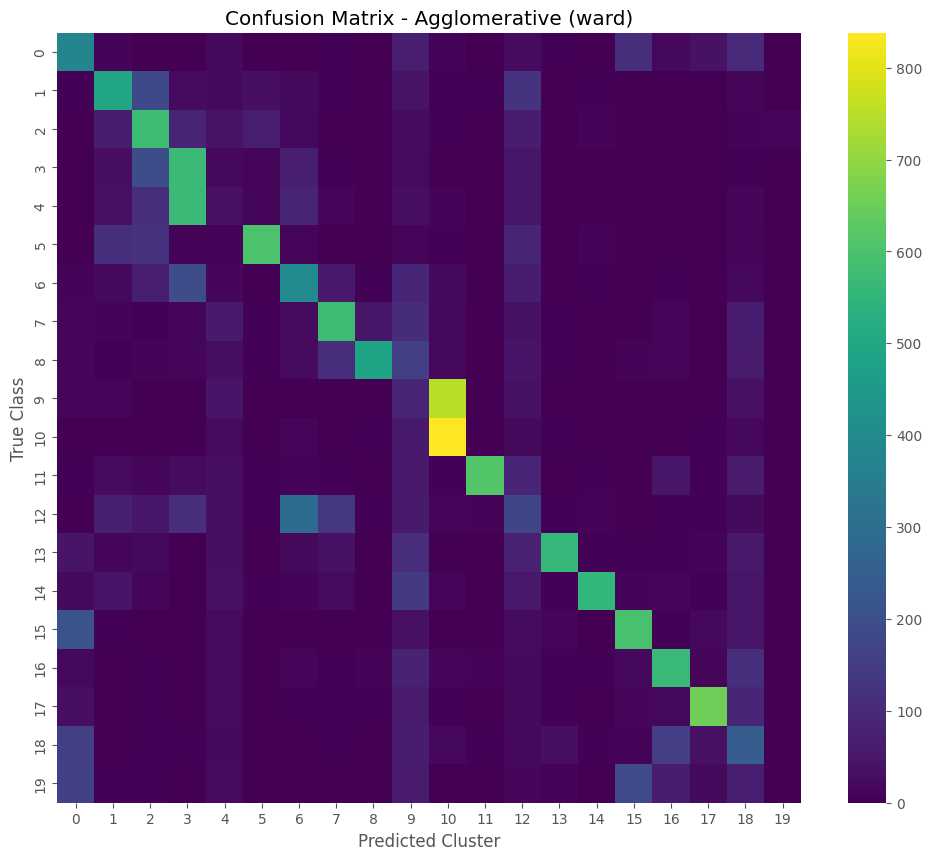


Agglomerative Clustering with single linkage:
Homogeneity: 0.0124
Completeness: 0.1468
V-measure: 0.0229
ARI: 0.0001
AMI: 0.0172


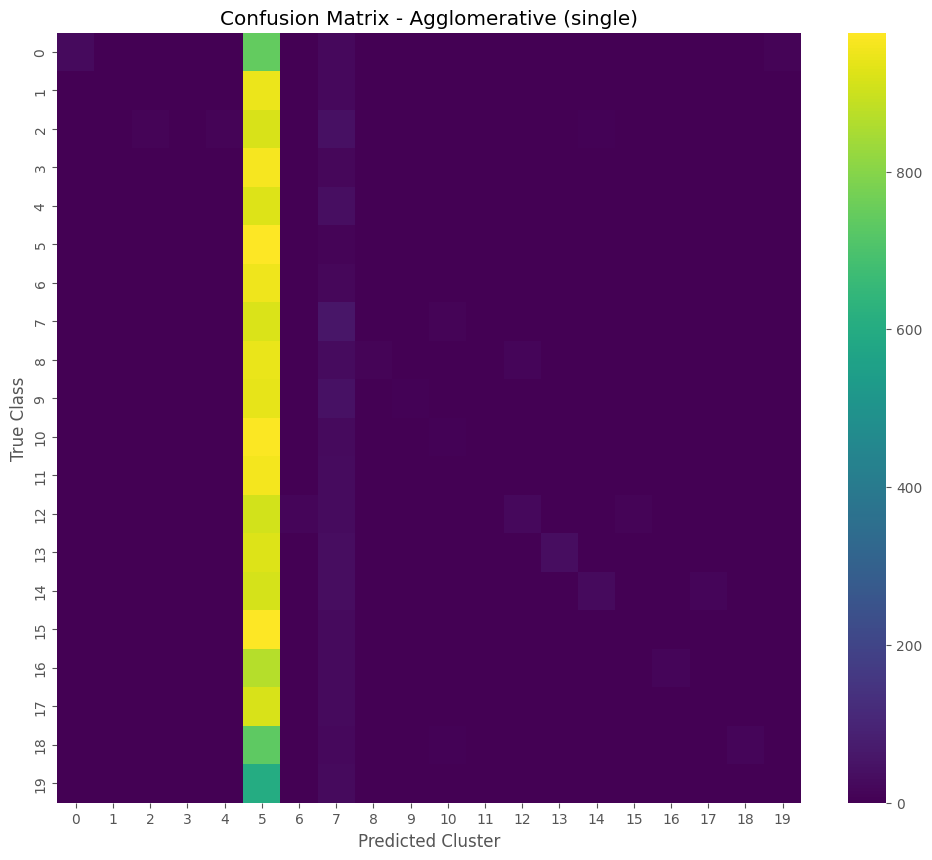

In [13]:

# UMAP reduction
reducer = umap.UMAP(n_components=5, metric='cosine', random_state=42)
umap_embedding = reducer.fit_transform(tfidf_matrix)


linkages = ['ward', 'single']
for linkage in linkages:
    print(f"\nAgglomerative Clustering with {linkage} linkage:")
    clustering = AgglomerativeClustering(n_clusters=20, linkage=linkage)
    labels = clustering.fit_predict(umap_embedding)
    
    # Calculate and print metrics
    print(f"Homogeneity: {homogeneity_score(newsgroups.target, labels):.4f}")
    print(f"Completeness: {completeness_score(newsgroups.target, labels):.4f}")
    print(f"V-measure: {v_measure_score(newsgroups.target, labels):.4f}")
    print(f"ARI: {adjusted_rand_score(newsgroups.target, labels):.4f}")
    print(f"AMI: {adjusted_mutual_info_score(newsgroups.target, labels):.4f}")
    
    # Plot confusion matrix
    cm = confusion_matrix(newsgroups.target, labels)
    rows, cols = linear_sum_assignment(cm, maximize=True)
    cm_optimized = cm[rows[:, np.newaxis], cols]
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_optimized, cmap='viridis', annot=False)
    plt.title(f'Confusion Matrix - Agglomerative ({linkage})')
    plt.xlabel('Predicted Cluster')
    plt.ylabel('True Class')
    plt.show()

# Question 15: HDBSCAN Analysis

In [14]:
# Load dataset and preprocess
newsgroups_data = fetch_20newsgroups(subset='all', random_state=0)
tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=3)
tfidf_vectors = tfidf_vectorizer.fit_transform(newsgroups_data.data)

# UMAP dimensionality reduction
umap_reducer = umap.UMAP(n_components=2, random_state=0)
umap_data = umap_reducer.fit_transform(tfidf_vectors)

# Store results
results = []
min_cluster_sizes = [20, 100, 200]

# Clustering and evaluation
for min_size in min_cluster_sizes:
    hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=min_size)
    cluster_labels = hdbscan_clusterer.fit_predict(umap_data)
    
    # Calculate metrics
    metrics = {
        'min_cluster_size': min_size,
        'homogeneity': homogeneity_score(newsgroups_data.target, cluster_labels),
        'completeness': completeness_score(newsgroups_data.target, cluster_labels),
        'v_measure': v_measure_score(newsgroups_data.target, cluster_labels),
        'adjusted_rand': adjusted_rand_score(newsgroups_data.target, cluster_labels),
        'adjusted_mutual_info': adjusted_mutual_info_score(newsgroups_data.target, cluster_labels),
        'num_clusters': len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0),
        'noise_points': np.sum(cluster_labels == -1)
    }
    results.append(metrics)
    
    # Print results
    print(f"\nResults for min_cluster_size = {min_size}:")
    for key, value in metrics.items():
        if key != 'min_cluster_size':
            print(f"{key}: {value:.4f}")


Results for min_cluster_size = 20:
homogeneity: 0.4323
completeness: 0.3654
v_measure: 0.3960
adjusted_rand: 0.0604
adjusted_mutual_info: 0.3769
num_clusters: 177.0000
noise_points: 7314.0000

Results for min_cluster_size = 100:
homogeneity: 0.0138
completeness: 0.4239
v_measure: 0.0267
adjusted_rand: 0.0006
adjusted_mutual_info: 0.0261
num_clusters: 2.0000
noise_points: 106.0000

Results for min_cluster_size = 200:
homogeneity: 0.0137
completeness: 0.4090
v_measure: 0.0265
adjusted_rand: 0.0006
adjusted_mutual_info: 0.0259
num_clusters: 2.0000
noise_points: 117.0000


# Question 16: Best Model Analysis

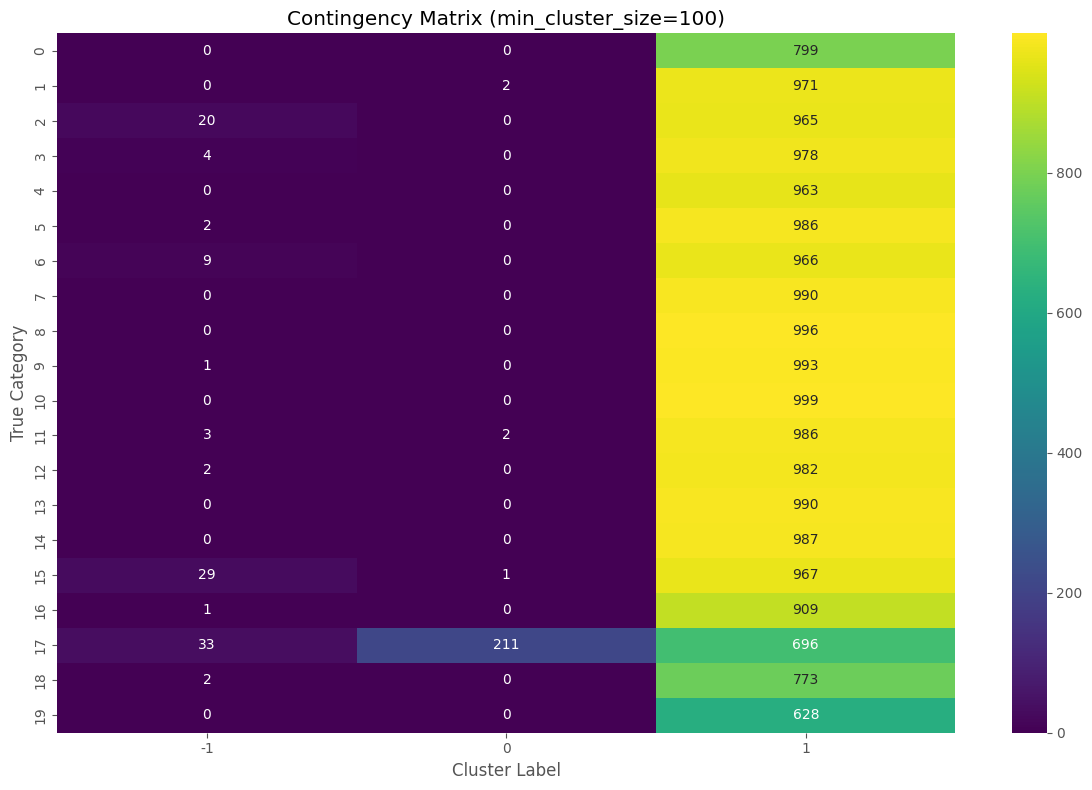

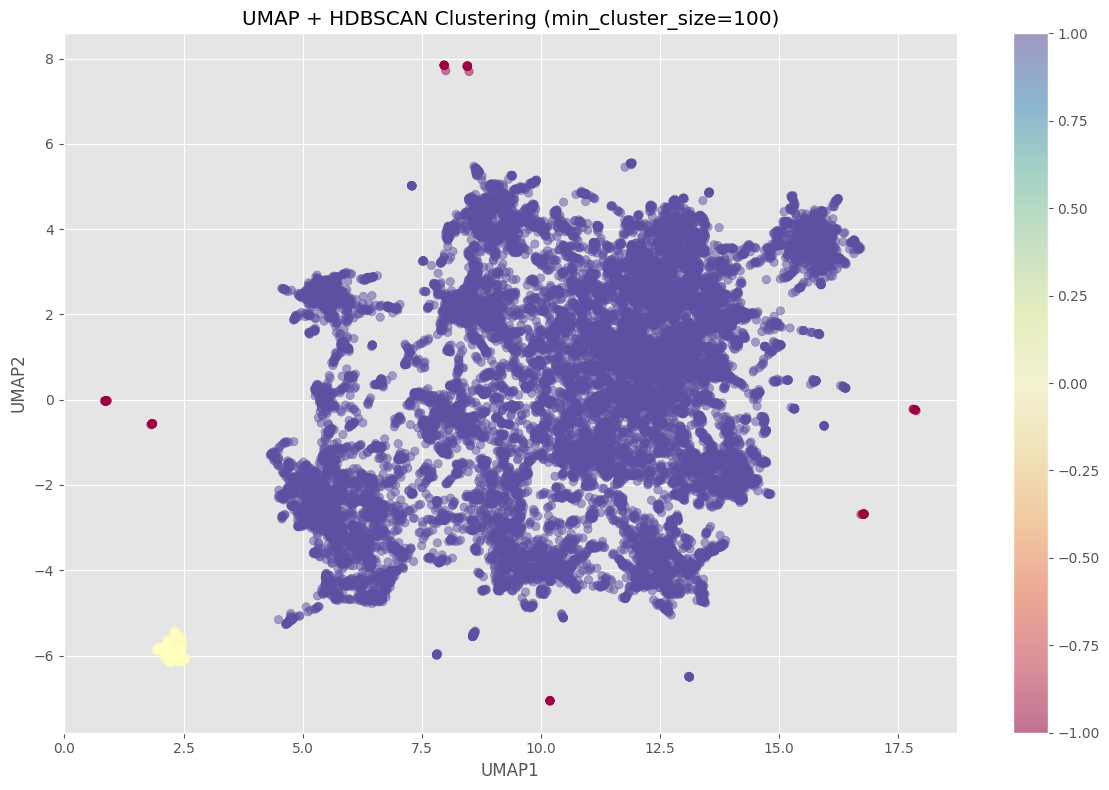


Final Clustering Statistics:
Number of clusters: 2
Noise points: 106
Noise percentage: 0.56%


In [15]:
# Create contingency matrix visualization
best_result_idx = np.argmax([r['completeness'] for r in results])
best_min_size = min_cluster_sizes[best_result_idx]

final_clusterer = hdbscan.HDBSCAN(min_cluster_size=best_min_size)
final_labels = final_clusterer.fit_predict(umap_data)

# Plot contingency matrix
plt.figure(figsize=(12, 8))
contingency = pd.crosstab(newsgroups_data.target, final_labels)
sns.heatmap(contingency, annot=True, fmt='d', cmap='viridis')
plt.title(f'Contingency Matrix (min_cluster_size={best_min_size})')
plt.xlabel('Cluster Label')
plt.ylabel('True Category')
plt.tight_layout()
plt.show()

# Scatter plot of UMAP results
plt.figure(figsize=(12, 8))
scatter = plt.scatter(umap_data[:, 0], umap_data[:, 1], 
                     c=final_labels, cmap='Spectral',
                     alpha=0.5)
plt.colorbar(scatter)
plt.title(f'UMAP + HDBSCAN Clustering (min_cluster_size={best_min_size})')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.tight_layout()
plt.show()

# Print final statistics
print("\nFinal Clustering Statistics:")
print(f"Number of clusters: {results[best_result_idx]['num_clusters']}")
print(f"Noise points: {results[best_result_idx]['noise_points']}")
print(f"Noise percentage: {results[best_result_idx]['noise_points']/len(final_labels)*100:.2f}%")

# Question17  
In Question 17, the goal is to integrate and analyze the results from the previous experiments (Questions 10-16), rather than implementing new functionality. The previous experiments already involved testing multiple dimensionality reduction techniques (such as TF-IDF, SVD, NMF, UMAP) and clustering algorithms (like K-Means, Agglomerative Clustering, and HDBSCAN). For each of these methods, performance was evaluated using clustering metrics such as V-Measure, ARI, AMI, Homogeneity, and Completeness. And these have already been done in previous questions. Rerun takes long time. Therefore, we didn't add any additional coding here.

The analyze details could be seen in the report. :)

# Question18

Loading and preprocessing data...
Testing different dimension reduction pipelines...

Processing pipeline: SVD+UMAP
Completed SVD+UMAP: V-measure=0.384, Time=15.7s

Processing pipeline: NMF+UMAP
Completed NMF+UMAP: V-measure=0.216, Time=50.8s

Processing pipeline: UMAP
Completed UMAP: V-measure=0.509, Time=60.7s

Processing pipeline: TSNE
Error in TSNE: PCA initialization is currently not supported with the sparse input matrix. Use init="random" instead.

Processing pipeline: PCA+UMAP
Completed PCA+UMAP: V-measure=0.374, Time=24.0s

Best dimensionality reduction pipeline: UMAP
  dim_reduction  v_measure  adjusted_rand  silhouette    runtime  num_clusters
2          UMAP   0.508857       0.352272    0.351794  60.742068            20
0      SVD+UMAP   0.383516       0.223468    0.412148  15.722935            20
3      PCA+UMAP   0.374384       0.207709    0.443561  24.014938            20
1      NMF+UMAP   0.216368       0.110983    0.426445  50.836113            20

Applying best pipeli

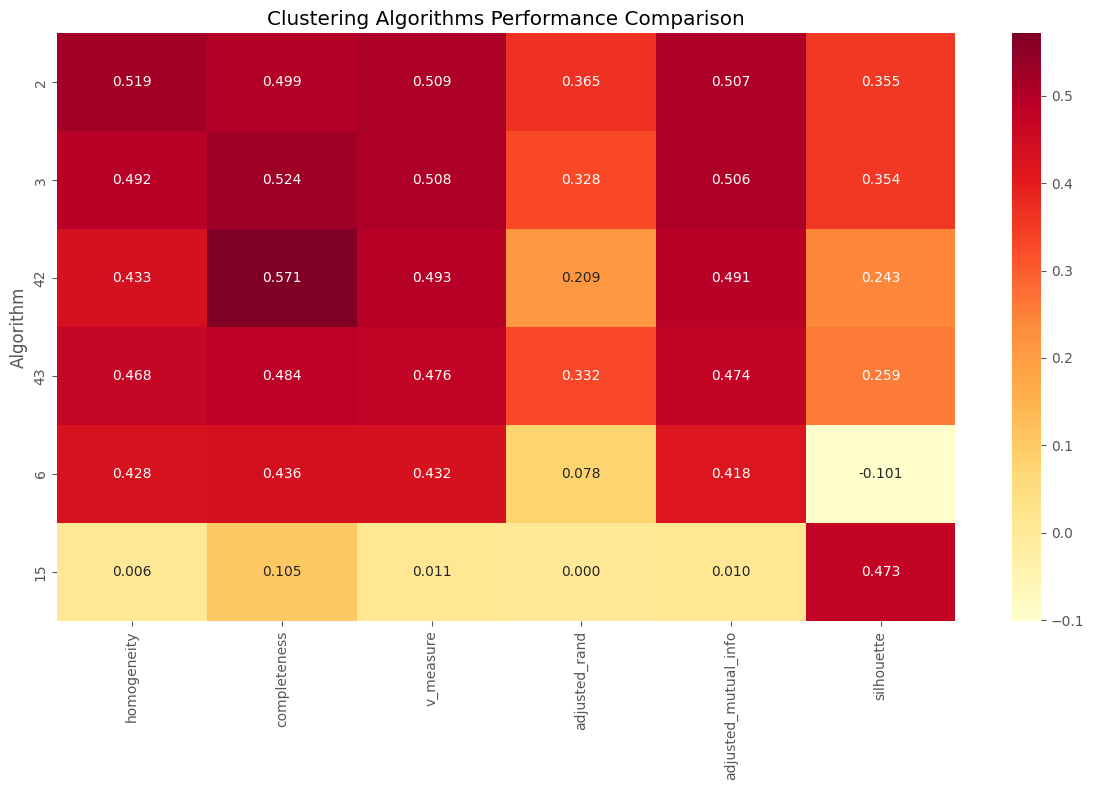

In [16]:
random_state = 42

# 1. Data preprocessing
print("Loading and preprocessing data...")

# Fetch 20 newsgroups dataset, removing headers, footers, and quotes
newsgroups_data = fetch_20newsgroups(
    subset='all',
    random_state=random_state,
    remove=('headers', 'footers', 'quotes')  # Remove structured noise (headers, footers, and quotes)
)

# Create a stemmer for text processing
stemmer = SnowballStemmer("english")

# Custom text processor: removes non-alphabetic characters and applies stemming
def text_processor(text):
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)  # Remove non-alphabetic characters
    tokens = text.lower().split()  # Convert text to lowercase and split into tokens
    return [stemmer.stem(word) for word in tokens if len(word) > 2]  # Apply stemming and filter out short words

# TF-IDF feature extraction with custom tokenizer and optimizations
tfidf_vectorizer = TfidfVectorizer(
    tokenizer=text_processor,
    stop_words='english',  # Remove common stop words in English
    min_df=5,              # Ignore words that appear in fewer than 5 documents
    max_df=0.85,           # Ignore words that appear in more than 85% of the documents
    ngram_range=(1,2),     # Include unigrams and bigrams
    sublinear_tf=True,     # Use logarithmic scaling for term frequency
    max_features=20000    # Limit the number of features to the top 20,000 most frequent terms
)

# Transform the text data into TF-IDF vectors
tfidf_vectors = tfidf_vectorizer.fit_transform(newsgroups_data.data)

# 2. Test different dimension reduction pipelines and choose the optimal one
print("Testing different dimension reduction pipelines...")

# Define different dimension reduction pipelines (SVD+UMAP, NMF+UMAP, etc.)
dim_reduction_pipelines = {
    'SVD+UMAP': [
        ('svd', TruncatedSVD(n_components=100, random_state=random_state)),  # Initial SVD dimensionality reduction
        ('normalize', None),  # No normalization step
        ('umap', umap.UMAP(n_components=10, n_neighbors=30, min_dist=0.1, metric='cosine', random_state=random_state)),  # UMAP for further dimensionality reduction
        ('scale', StandardScaler())  # Standardize features (mean=0, variance=1)
    ],
    'NMF+UMAP': [
        ('nmf', NMF(n_components=100, init='nndsvda', max_iter=1000, random_state=random_state)),  # Non-negative matrix factorization (NMF) for dimensionality reduction
        ('normalize', None),
        ('umap', umap.UMAP(n_components=10, n_neighbors=30, min_dist=0.1, metric='cosine', random_state=random_state)),
        ('scale', StandardScaler())
    ],
    'UMAP': [
        ('umap', umap.UMAP(n_components=10, n_neighbors=30, min_dist=0.1, metric='cosine', random_state=random_state)),
        ('scale', StandardScaler())
    ],
    'TSNE': [
        ('tsne', TSNE(n_components=2, random_state=random_state)),  # t-SNE for non-linear dimensionality reduction
        ('scale', StandardScaler())
    ],
    'PCA+UMAP': [
        ('pca', PCA(n_components=100, random_state=random_state)),  # Principal component analysis (PCA)
        ('normalize', None),
        ('umap', umap.UMAP(n_components=10, n_neighbors=30, min_dist=0.1, metric='cosine', random_state=random_state)),
        ('scale', StandardScaler())
    ]
}

dim_reduction_results = []

# Apply each dimensionality reduction pipeline and measure clustering performance
for pipe_name, steps in dim_reduction_pipelines.items():
    print(f"\nProcessing pipeline: {pipe_name}")
    start_time = time()
    
    try:
        current_vectors = tfidf_vectors.copy()  # Copy the TF-IDF vectors
        
        for step_info in steps:
            step_name, step = step_info
            
            if step_name == 'normalize':  # If normalization step is specified
                current_vectors = normalize(current_vectors)  # Normalize data
            elif step_name == 'scale':  # If scaling step is specified
                scaler = StandardScaler()
                current_vectors = scaler.fit_transform(current_vectors)  # Standardize features
            else:
                if step_name == 'pca':  # If PCA is applied, convert sparse matrix to dense
                    if hasattr(current_vectors, 'toarray'):
                        current_vectors = current_vectors.toarray()
                current_vectors = step.fit_transform(current_vectors)  # Apply the dimensionality reduction step
        
        # Evaluate clustering performance using KMeans
        kmeans = KMeans(n_clusters=20, n_init=10, random_state=random_state)
        labels = kmeans.fit_predict(current_vectors)
        
        # Store evaluation metrics for this pipeline
        metrics = {
            'dim_reduction': pipe_name,
            'v_measure': v_measure_score(newsgroups_data.target, labels),  # V-measure (clustering quality metric)
            'adjusted_rand': adjusted_rand_score(newsgroups_data.target, labels),  # Adjusted Rand index
            'silhouette': silhouette_score(current_vectors, labels, sample_size=10000, random_state=random_state),  # Silhouette score
            'runtime': time() - start_time,  # Time taken to run the pipeline
            'num_clusters': len(np.unique(labels))  # Number of clusters
        }
        
        dim_reduction_results.append(metrics)  # Append results to the list
        print(f"Completed {pipe_name}: V-measure={metrics['v_measure']:.3f}, Time={metrics['runtime']:.1f}s")
        
    except Exception as e:
        print(f"Error in {pipe_name}: {str(e)}")
        continue

# Select the optimal dimension reduction pipeline based on V-measure
dim_reduction_df = pd.DataFrame(dim_reduction_results).sort_values('v_measure', ascending=False)
best_pipe_name = dim_reduction_df.iloc[0]['dim_reduction']
best_pipe_steps = dim_reduction_pipelines[best_pipe_name]

print("\nBest dimensionality reduction pipeline:", best_pipe_name)
print(dim_reduction_df)

# Apply the best pipeline to the data
print(f"\nApplying best pipeline: {best_pipe_name}")
current_vectors = tfidf_vectors.copy()
for step_info in best_pipe_steps:
    step_name, step = step_info
    if step_name == 'normalize':
        current_vectors = normalize(current_vectors)
    elif step_name == 'scale':
        scaler = StandardScaler()
        current_vectors = scaler.fit_transform(current_vectors)
    else:
        if step_name == 'pca':
            if hasattr(current_vectors, 'toarray'):
                current_vectors = current_vectors.toarray()
        current_vectors = step.fit_transform(current_vectors)

scaled_vectors = current_vectors

# 3. Define the clustering algorithms to test and their parameters
clustering_algorithms = {
    'KMeans': [
        KMeans(n_clusters=n_clusters, n_init=10, random_state=random_state)
        for n_clusters in [15, 20, 25]  # Test different cluster sizes
    ],
    'Agglomerative': [
        AgglomerativeClustering(n_clusters=20, linkage=linkage)
        for linkage in ['ward', 'complete', 'average']  # Test different linkage methods
    ],
    'DBSCAN': [
        DBSCAN(eps=eps, min_samples=min_samples)
        for eps in [0.3, 0.5, 0.7]
        for min_samples in [10, 15, 20]  # Test different values for epsilon and min_samples
    ],
    'HDBSCAN': [
        hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            cluster_selection_epsilon=epsilon,
            cluster_selection_method='eom',
            core_dist_n_jobs=1  # Disable parallel computation for HDBSCAN
        )
        for min_cluster_size in [50, 80, 100]
        for min_samples in [10, 15, 20]
        for epsilon in [0.2, 0.3, 0.4]
    ],
    'Spectral': [
        SpectralClustering(
            n_clusters=20,
            n_init=10,
            affinity='nearest_neighbors',
            random_state=random_state
        )
    ],
    'BIRCH': [
        Birch(n_clusters=20, threshold=threshold)
        for threshold in [0.3, 0.5, 0.7]  # Test different threshold values
    ]
}

# 4. Run clustering algorithms and evaluate the results
results = []

for algo_name, algo_list in clustering_algorithms.items():
    print(f"\nTesting {algo_name}...")
    
    for algo in algo_list:
        try:
            start_time = time()
            
            # Perform clustering
            labels = algo.fit_predict(scaled_vectors)
            
            # Calculate evaluation metrics
            metrics = {
                'algorithm': algo_name,
                'parameters': str(algo.get_params()),  # Parameters used for this algorithm
                'homogeneity': homogeneity_score(newsgroups_data.target, labels),  # Homogeneity score
                'completeness': completeness_score(newsgroups_data.target, labels),  # Completeness score
                'v_measure': v_measure_score(newsgroups_data.target, labels),  # V-measure score
                'adjusted_rand': adjusted_rand_score(newsgroups_data.target, labels),  # Adjusted Rand score
                'adjusted_mutual_info': adjusted_mutual_info_score(newsgroups_data.target, labels),  # Mutual Information score
                'num_clusters': len(set(labels)) - (1 if -1 in labels else 0),  # Number of clusters (ignoring noise points)
                'noise_ratio': np.sum(labels == -1) / len(labels) if -1 in labels else 0.0,  # Ratio of noise points (for DBSCAN and HDBSCAN)
                'runtime': time() - start_time  # Time taken for clustering
            }
            
            # Attempt to calculate silhouette score
            try:
                metrics['silhouette'] = silhouette_score(
                    scaled_vectors, 
                    labels,
                    sample_size=min(10000, len(labels)),  # Limit sample size for silhouette score
                    random_state=random_state
                )
            except:
                metrics['silhouette'] = 0.0  # Set silhouette score to 0 if not available
                
            results.append(metrics)
            print(f"Completed {algo_name} with params: {metrics['parameters']}")
            
        except Exception as e:
            print(f"Error with {algo_name}: {str(e)}")
            continue

# 5. analyze the results
results_df = pd.DataFrame(results)

# Get the best results for each algorithm based on V-measure
best_results = results_df.loc[results_df.groupby('algorithm')['v_measure'].idxmax()]
best_results = best_results.sort_values('v_measure', ascending=False)

# Print the best results
print("\nBest results for each algorithm:")
print(best_results[['algorithm', 'v_measure', 'num_clusters', 'runtime', 'parameters']])

# 6. Visualize the results
plt.figure(figsize=(12, 8))
metrics_cols = ['homogeneity', 'completeness', 'v_measure', 
                'adjusted_rand', 'adjusted_mutual_info', 'silhouette']

sns.heatmap(best_results[metrics_cols], annot=True, fmt='.3f', cmap='YlOrRd')
plt.title('Clustering Algorithms Performance Comparison')
plt.ylabel('Algorithm')
plt.tight_layout()
plt.show()

# 7. save the results to a CSV file
best_results.to_csv('clustering_results.csv', index=False)

In [17]:
best_results

,algorithm,parameters,homogeneity,completeness,v_measure,adjusted_rand,adjusted_mutual_info,num_clusters,noise_ratio,runtime,silhouette
2,KMeans,"{'algorithm': 'lloyd', 'copy_x': True, 'init':...",0.519179,0.499208,0.508998,0.364525,0.507013,25,0.000000,2.039112,0.354505
3,Agglomerative,"{'compute_distances': False, 'compute_full_tre...",0.492253,0.524221,0.507734,0.328443,0.506075,20,0.000000,3.111499,0.354047
42,Spectral,"{'affinity': 'nearest_neighbors', 'assign_labe...",0.433359,0.571468,0.492922,0.209408,0.490975,20,0.000000,5.925280,0.243099
43,BIRCH,"{'branching_factor': 50, 'compute_labels': Tru...",0.468170,0.483911,0.475910,0.332086,0.474190,20,0.000000,0.366549,0.258976
6,DBSCAN,"{'algorithm': 'auto', 'eps': 0.3, 'leaf_size':...",0.428106,0.436402,0.432214,0.078132,0.417814,133,0.400456,0.172848,-0.100862
15,HDBSCAN,"{'algorithm': 'best', 'allow_single_cluster': ...",0.006048,0.105337,0.011440,0.000131,0.010414,3,0.001380,0.450211,0.473220


In [18]:
best_results['parameters']

2     {'algorithm': 'lloyd', 'copy_x': True, 'init':...
3     {'compute_distances': False, 'compute_full_tre...
42    {'affinity': 'nearest_neighbors', 'assign_labe...
43    {'branching_factor': 50, 'compute_labels': Tru...
6     {'algorithm': 'auto', 'eps': 0.3, 'leaf_size':...
15    {'algorithm': 'best', 'allow_single_cluster': ...
Name: parameters, dtype: object